# Neural Style Transfer

This code was taken and modified from TensorFlow neural style transfer tutorial: https://www.tensorflow.org/tutorials/generative/style_transfer

In [250]:
import os
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time
import functools

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

### Visualize the input

In [ ]:
# content image and style image path
content_path = '/Users/fuqianzou/Desktop/Document/Northwestern MLDS/432 Deep Learning/Project/Pets Facial Expression/happy/043.jpg'
style_path = '/Users/fuqianzou/Desktop/Document/Northwestern MLDS/432 Deep Learning/Project/Van_Gogh.jpg'

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
# Define image loading and visualization functions 
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img


def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

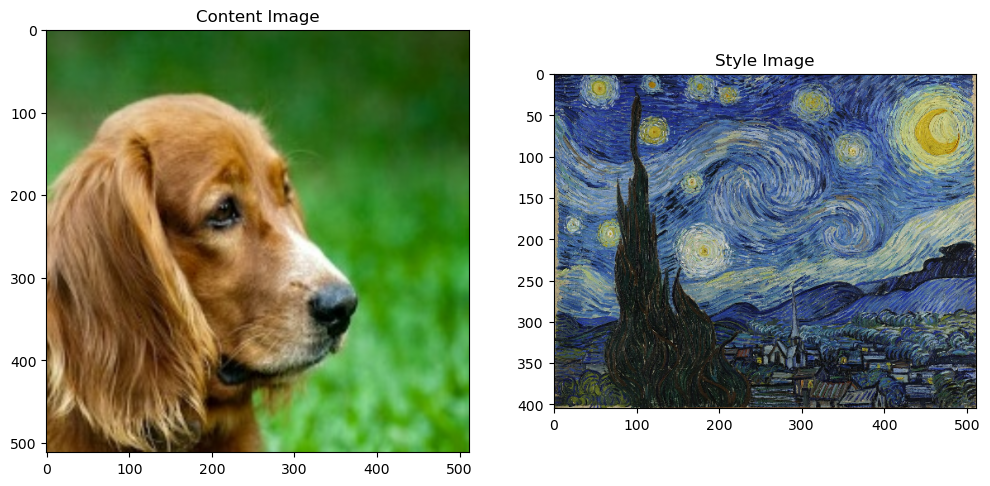

In [ ]:
# visualize the content image and style image
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

### Build the model to extract style and content

In [ ]:
# load VGG19 model
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [287]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Egyptian_cat', 0.20369153),
 ('carton', 0.122187346),
 ('kit_fox', 0.12063997),
 ('red_fox', 0.07447831),
 ('tiger_cat', 0.06337008)]

In [ ]:
# load VGG19 model without the classification head
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_layer_28
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
# choose intermediate layers from the network to represent the style and content of the image
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
# output intermediate layers of the model and build the model as extractor
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

/opt/anaconda3/envs/zfq0/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_670']. Received: the structure of inputs=*
  warnings.warn(


In [292]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
# Build a model that returns the style and content tensors
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [294]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

/opt/anaconda3/envs/zfq0/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_692']. Received: the structure of inputs=*
  warnings.warn(


### Run the style transfer algorithm with gradient decent optimization

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
# funtion to calculate the total loss
style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
# Choose a weight for the total_variation_loss
total_variation_weight=30

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [298]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

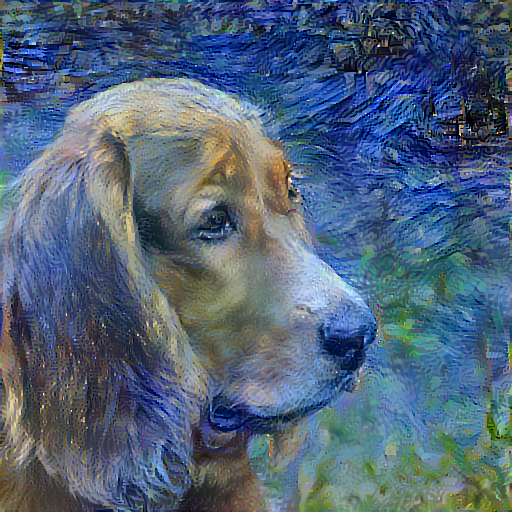

Train step: 1000
Total time: 1251.9


In [ ]:
# run the style transfer algorithm
import time
start = time.time()

epoch_images = []
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  epoch_images.append(tensor_to_image(image).copy())

end = time.time()
print("Total time: {:.1f}".format(end-start))

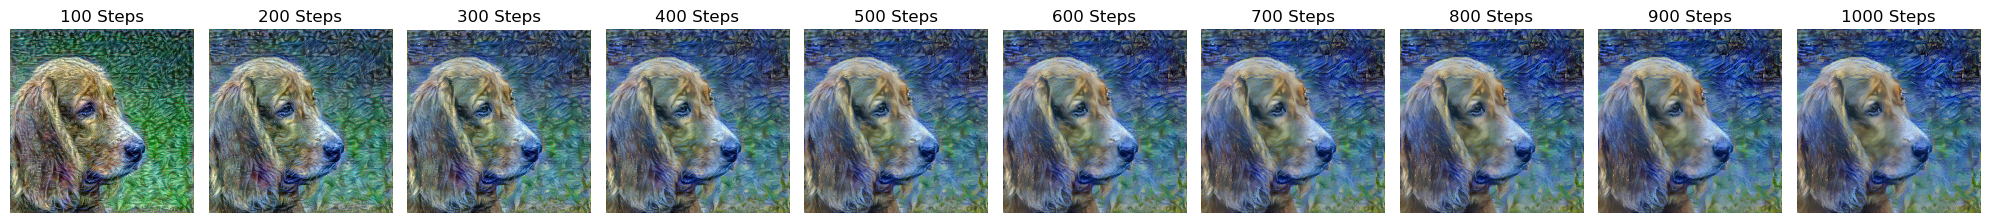

In [ ]:
# visualize the style transfer results of each 100 steps
plt.figure(figsize=(20, 8))
for i, img in enumerate(epoch_images):
    plt.subplot(1, 10, i+1) 
    plt.imshow(img)
    plt.title(f"{(i+1)*100} Steps")
    plt.axis('off')
plt.tight_layout()
plt.show()

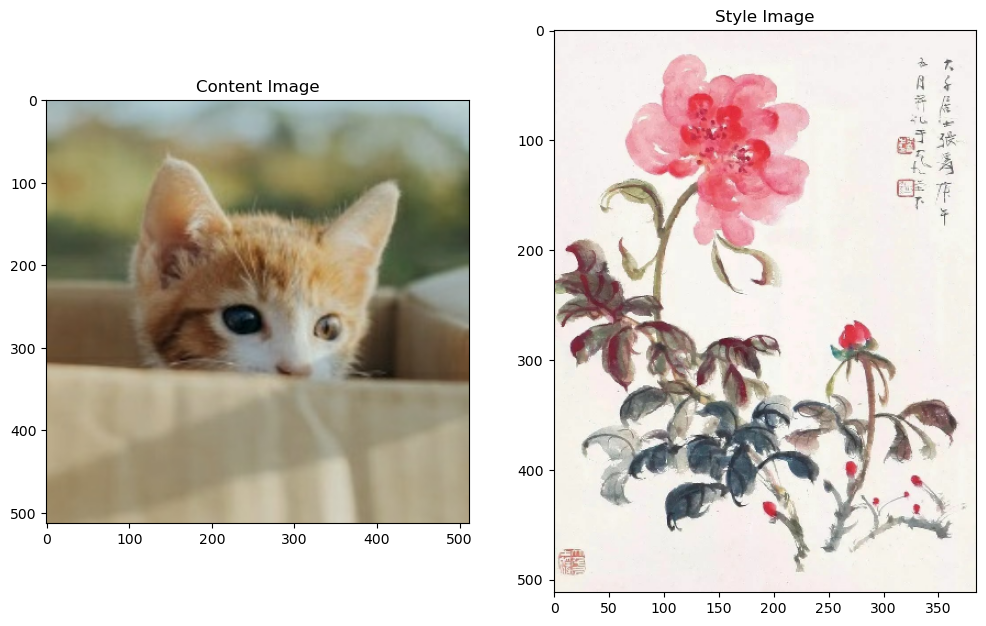

In [ ]:
# try another example (after runing this block, need to rerun the previous blocks before generating new image)
content_path = '/Users/fuqianzou/Desktop/Document/Northwestern MLDS/432 Deep Learning/Project/Pets Facial Expression/Other/03.jpg'
style_path = '/Users/fuqianzou/Desktop/Document/Northwestern MLDS/432 Deep Learning/Project/Daqian_Zhang.jpg'

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

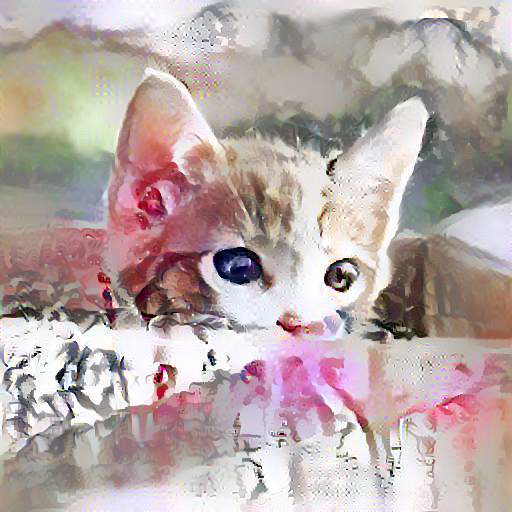

Train step: 1000
Total time: 1255.4


In [ ]:
import time
start = time.time()

epoch_images = []
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  epoch_images.append(tensor_to_image(image).copy())

end = time.time()
print("Total time: {:.1f}".format(end-start))

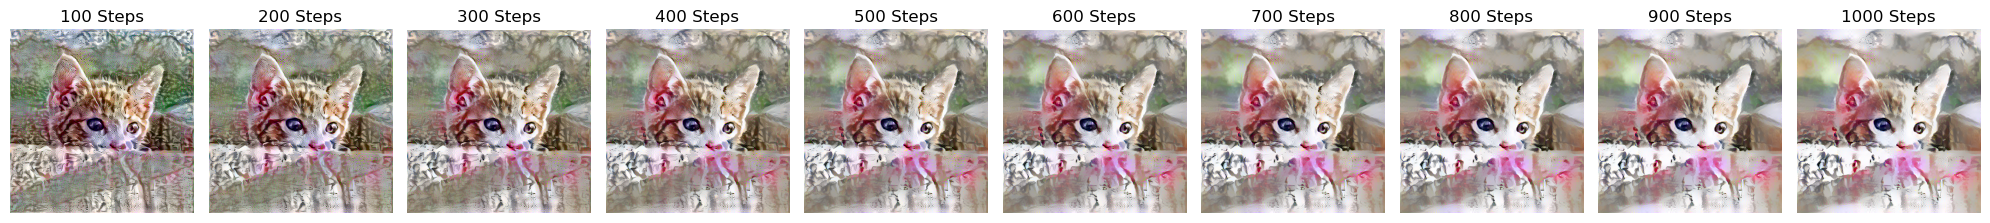

In [300]:
plt.figure(figsize=(20, 8))
for i, img in enumerate(epoch_images):
    plt.subplot(1, 10, i+1) 
    plt.imshow(img)
    plt.title(f"{(i+1)*100} Steps")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Fast Style Transfer

This code was taken and modified from TensorFlow fast style transfer tutorial: https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization

In [210]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.18.0
TF Hub version:  0.16.1
Eager mode enabled:  True
GPU available:  []


In [ ]:
# Define image loading and visualization functions
def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_path, image_size=(256, 256), preserve_aspect_ratio=True):
    """Loads and preprocesses images from local files."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    img = tf.io.decode_image(
        tf.io.read_file(image_path),
        channels=3, dtype=tf.float32)[tf.newaxis, ...]
    img = crop_center(img)
    img = tf.image.resize(img, image_size, preserve_aspect_ratio=preserve_aspect_ratio)
    return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

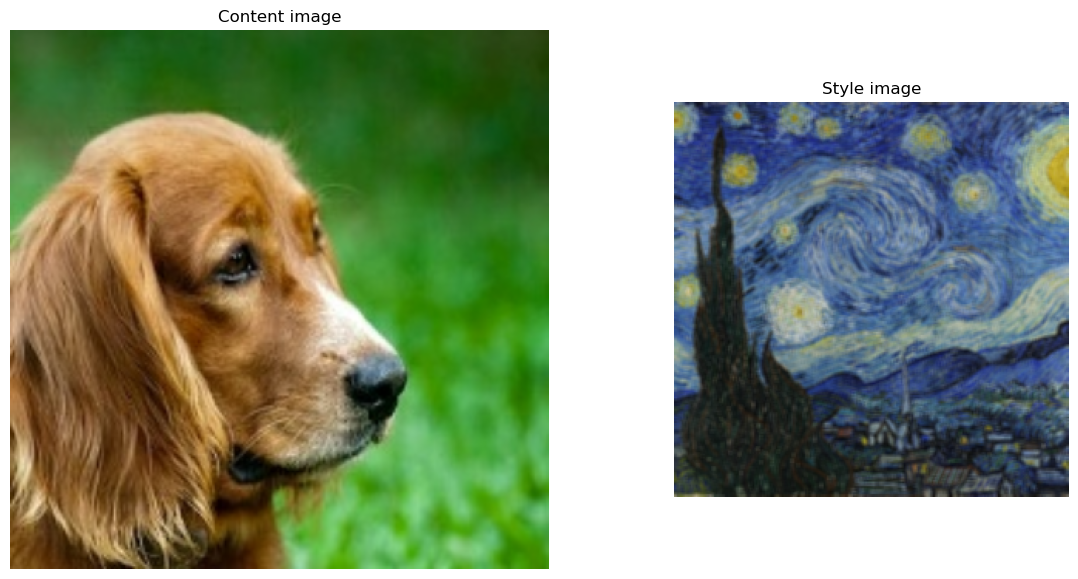

In [ ]:
# visualize the content image and style image
content_image = '/Users/fuqianzou/Desktop/Document/Northwestern MLDS/432 Deep Learning/Project/Pets Facial Expression/happy/043.jpg'  # @param {type:"string"}
style_image = '/Users/fuqianzou/Desktop/Document/Northwestern MLDS/432 Deep Learning/Project/Van_Gogh.jpg'

output_image_size = 384
content_img_size = (output_image_size, output_image_size)
style_img_size = (256, 256)

content_image = load_image(content_image, content_img_size)
style_image = load_image(style_image, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

In [ ]:
# Load TF Hub module
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [ ]:
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

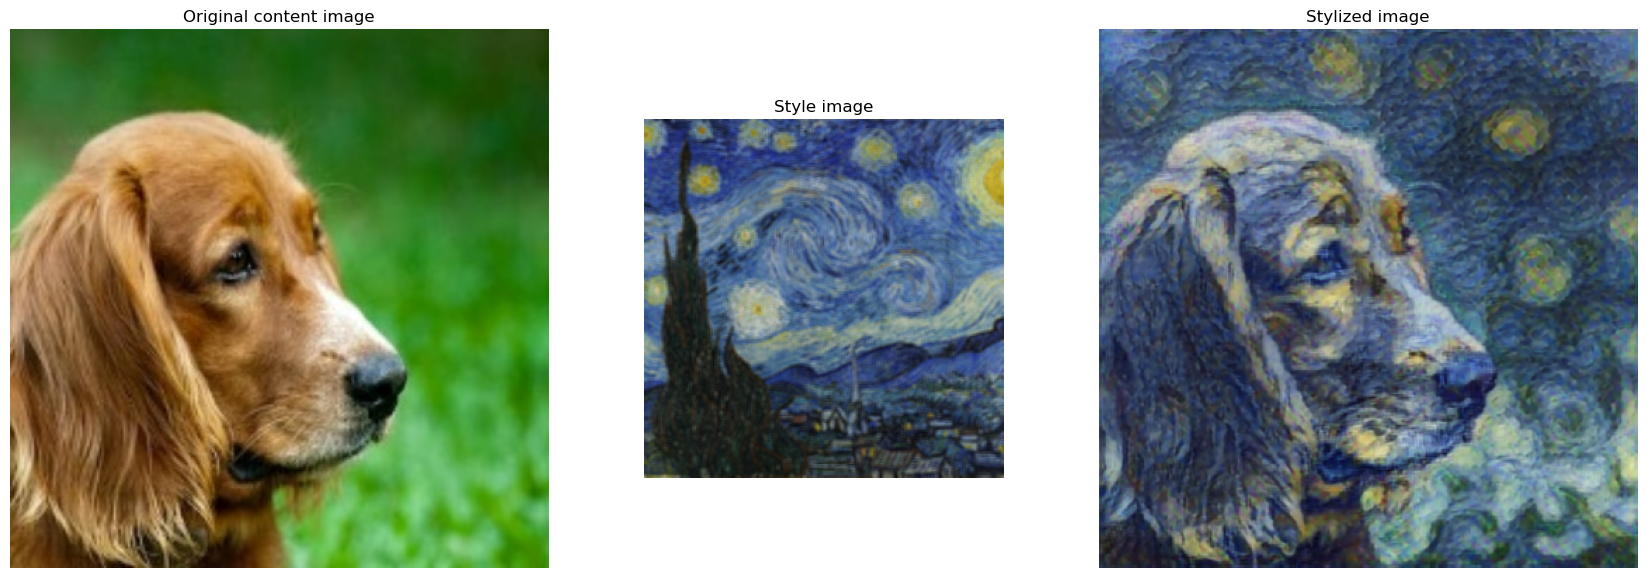

In [ ]:
# Visualize input images and the generated stylized image
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

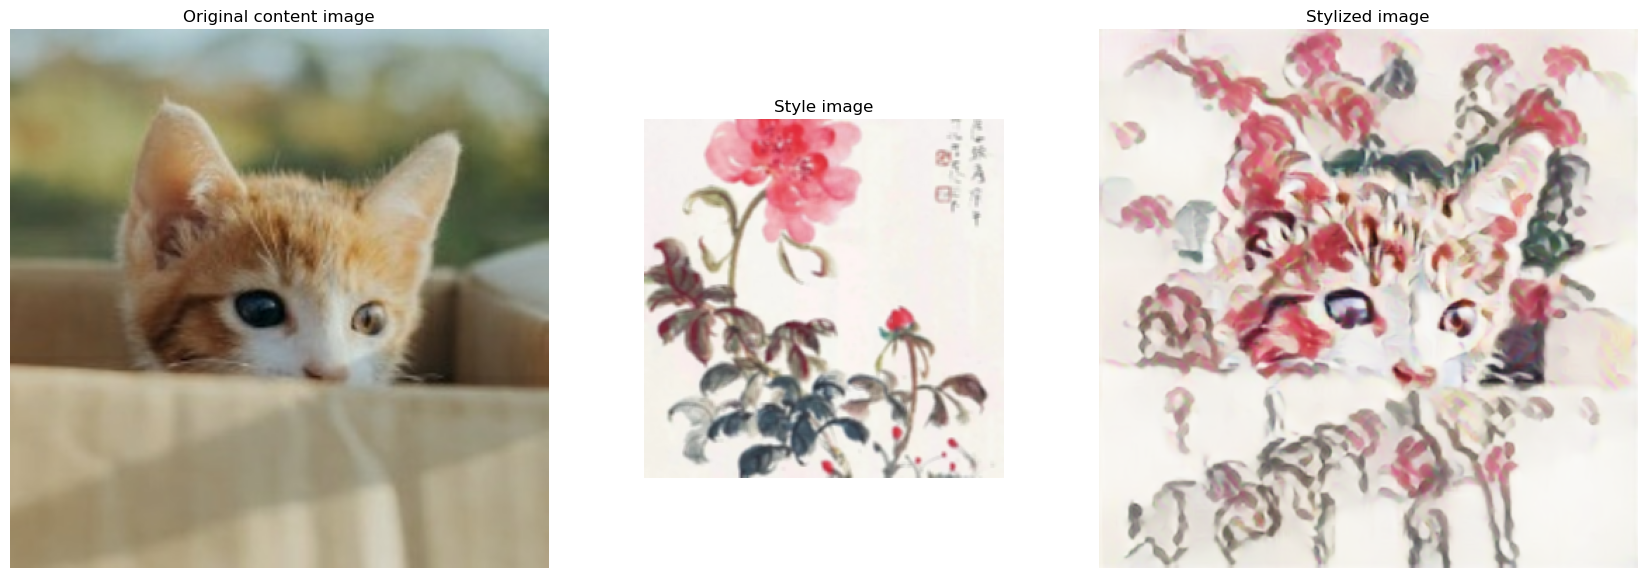

In [ ]:
# try another example
content_image = '/Users/fuqianzou/Desktop/Document/Northwestern MLDS/432 Deep Learning/Project/Pets Facial Expression/Other/03.jpg'
style_image = '/Users/fuqianzou/Desktop/Document/Northwestern MLDS/432 Deep Learning/Project/Daqian_Zhang.jpg'

content_img_size = (384, 384)
style_img_size = (256, 256)

content_image = load_image(content_image, content_img_size)
style_image = load_image(style_image, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])